In [378]:
# referrence:  https://keras.io/examples/timeseries/timeseries_weather_forecasting/
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.preprocessing import StandardScaler
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

In [379]:
DATA_DIR = '../../data/data_daily_with_aqi.csv'
raw_df = pd.read_csv(DATA_DIR)

In [380]:
raw_df.type.unique()

array(['O3_24h', 'NO2_24h', 'SO2_24h', 'PM2.5_24h', 'AQI'], dtype=object)

In [381]:
df = raw_df[raw_df['type']=='AQI'].drop('type',axis=1)
df = df.drop(['date','hour'],axis=1).reset_index(drop=True)

df['pm2.5'] = raw_df[raw_df['type']=='PM2.5_24h']['北京'].values.flatten()
df['o3'] = raw_df[raw_df['type']=='O3_24h']['北京'].values.flatten()
df['so2'] = raw_df[raw_df['type']=='SO2_24h']['北京'].values.flatten()
df['no2'] = raw_df[raw_df['type']=='NO2_24h']['北京'].values.flatten()

In [382]:
df = df.dropna(how='all')

In [383]:
step = 1
past = 200
future = 15
learning_rate = 1e-3
batch_size = 256
epochs = 500
sequence_length = 200

df = df.apply(np.log).diff(2)


df['label'] = df['北京'].shift(-future)
df =  df.fillna(method='ffill').dropna(how='any',axis=0)
df = df.reset_index(drop=True)

In [384]:

split_fraction = 0.7
train_split = int(split_fraction * int(df.shape[0]))

In [385]:
features = df.reset_index(drop=True)
# features = normalize(features.values, train_split)
# features = pd.DataFrame(features)
# features.head()
train_data = features.iloc[: train_split,:]
val_data = features.iloc[train_split-sequence_length:,:]

In [386]:
x_train = train_data.iloc[:,:-1].values
y_train = train_data.iloc[:,-1].values
x_val = val_data.iloc[:,:-1].values
y_val = val_data.iloc[:,-1].values
x_scaler = StandardScaler()
y_scaler = StandardScaler()
x_train = x_scaler.fit_transform(x_train)
x_val = x_scaler.transform(x_val)
y_train = y_scaler.fit_transform(y_train.reshape(-1,1))
y_val = y_scaler.transform(y_val.reshape(-1,1))


In [387]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [388]:
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.shape)
print("Target shape:", targets.shape)

Input shape: (256, 200, 17)
Target shape: (256, 1)


In [389]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(16)(inputs)
outputs = keras.layers.Dense(32)(lstm_out)
dropout = keras.layers.Dropout(0.5, noise_shape=None, seed=None)(outputs)
outputs2 = keras.layers.Dense(16)(dropout)
outputs3 = keras.layers.Dense(1)(outputs2)

model = keras.Model(inputs=inputs, outputs=outputs3)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 200, 17)]         0         
                                                                 
 lstm_18 (LSTM)              (None, 16)                2176      
                                                                 
 dense_54 (Dense)            (None, 32)                544       
                                                                 
 dropout_18 (Dropout)        (None, 32)                0         
                                                                 
 dense_55 (Dense)            (None, 16)                528       
                                                                 
 dense_56 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,265
Trainable params: 3,265
Non-trainable 

In [390]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=15, verbose=1, mode="auto", baseline=None, restore_best_weights=False)
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, 
               modelckpt_callback,
               ],
)

Epoch 1/500


2022-05-22 10:10:45.471074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-22 10:10:45.627366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-22 10:10:46.048058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 1.0816

2022-05-22 10:10:48.015477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-22 10:10:48.066788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.72405, saving model to model_checkpoint.h5
7/7 [==============================] - 4s 332ms/step - loss: 1.0816 - val_loss: 0.7240
Epoch 2/500
6/7 [========================>.....] - ETA: 0s - loss: 1.0886
Epoch 2: val_loss improved from 0.72405 to 0.71588, saving model to model_checkpoint.h5
7/7 [==============================] - 1s 101ms/step - loss: 1.0602 - val_loss: 0.7159
Epoch 3/500
6/7 [========================>.....] - ETA: 0s - loss: 1.0730
Epoch 3: val_loss improved from 0.71588 to 0.71193, saving model to model_checkpoint.h5
7/7 [==============================] - 1s 95ms/step - loss: 1.0426 - val_loss: 0.7119
Epoch 4/500
6/7 [========================>.....] - ETA: 0s - loss: 1.0618
Epoch 4: val_loss improved from 0.71193 to 0.70974, saving model to model_checkpoint.h5
7/7 [==============================] - 1s 93ms/step - loss: 1.0303 - val_loss: 0.7097
Epoch 5/500
7/7 [==============================] - ETA: 0s - loss: 1.0207
Epoch 5: 

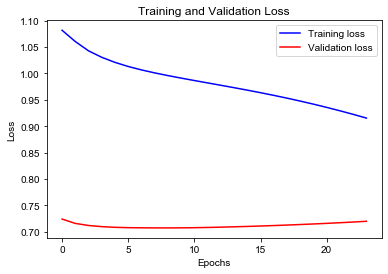

In [391]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

In [392]:

def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return



2022-05-22 10:11:03.531256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-22 10:11:03.570023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1s 25ms/step


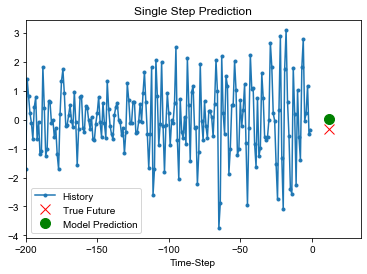

8/8 [==============================] - 0s 26ms/step


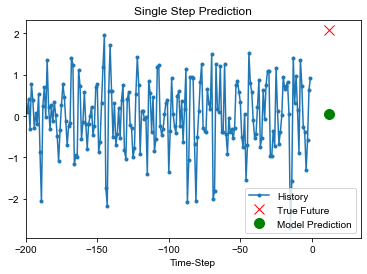

8/8 [==============================] - 0s 25ms/step


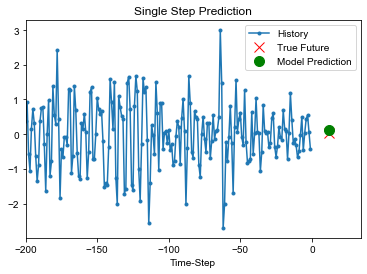

2022-05-22 10:11:04.810001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-22 10:11:04.850387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 453ms/step


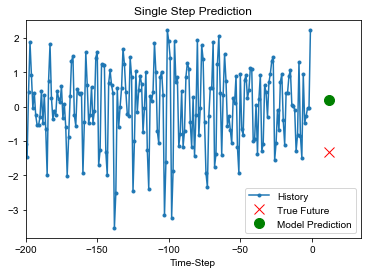

In [393]:
for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

2022-05-22 10:11:05.462974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-22 10:11:05.511984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 109ms/step


Text(0.5, 1.0, 'r2_score:-0.0295')

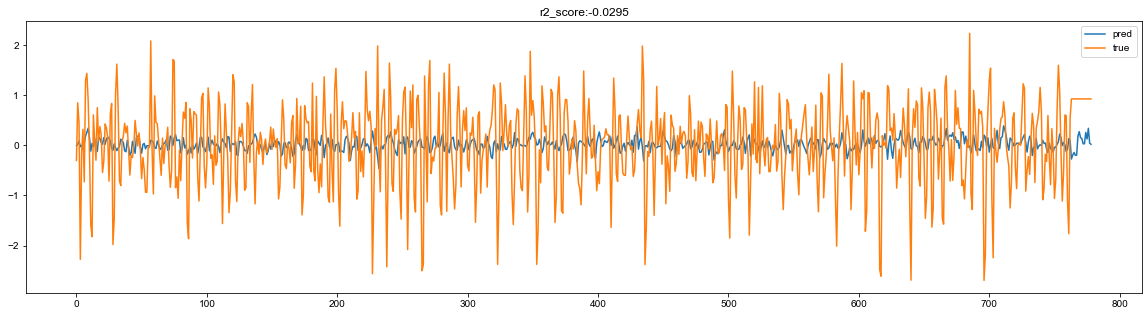

In [394]:
from sklearn.metrics import r2_score
pred = model.predict(dataset_val)
y_pred = pred
y_true = y_val.flatten()[-len(y_pred):]
plt.figure(figsize=(20, 5))
plt.plot(y_pred,label = 'pred')
plt.plot(y_true,label='true')
plt.legend()
plt.title('r2_score:{:.4f}'.format(r2_score(y_true,y_pred)))


In [395]:
model.save('./models/lstm_128_dense_1.h5')

7/7 [==============================] - 0s 72ms/step


Text(0.5, 1.0, 'r2_score:-0.0298')

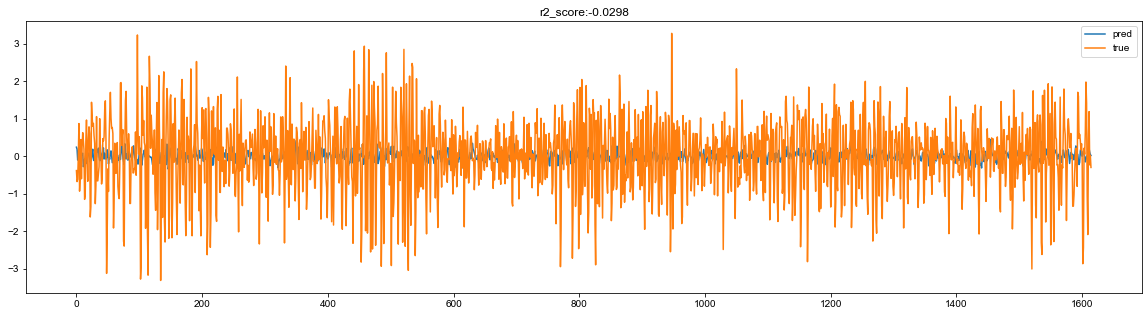

In [396]:
from sklearn.metrics import r2_score
pred = model.predict(dataset_train)
y_pred = pred
y_true = y_train.flatten()[-len(y_pred):]
plt.figure(figsize=(20, 5))
plt.plot(y_pred,label = 'pred')
plt.plot(y_true,label='true')
plt.legend()
plt.title('r2_score:{:.4f}'.format(r2_score(y_true,y_pred)))
